# Latent Diffusion Model Inference for Dark Sky Spectra

This notebook demonstrates how to:
1. Load and enrich DESI Sky Spectra VAC with solar flux and coordinate data
2. Load pre-trained VAE and LDM models
3. Generate conditional samples using the LatentDiffusionSampler

All functionality has been refactored into production-ready modules in `desisky`.

## Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 1 only

import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("JAX is using device:", jax.devices())

JAX is using device: [CudaDevice(id=0)]


## Load and Enrich Data

We'll load the DESI Sky Spectra VAC dark-time subset, which automatically filters for:
- Sun altitude < -20° (astronomical twilight)
- Moon altitude < -5° (Moon well below horizon)
- Valid transparency measurements

The data is enriched with solar flux and coordinate transformations.

In [2]:
from desisky.data import (
    SkySpecVAC,
    attach_solar_flux,
    add_galactic_coordinates,
    add_ecliptic_coordinates,
    get_validation_mask
)

# Load the VAC with dark-time subset
vac = SkySpecVAC(version="v1.0", download=True, verify=True)
print(f"Data file location: {vac.filepath()}")

# Load dark-time subset with enrichment (includes V-band magnitudes and eclipse fraction)
wavelength, flux, metadata = vac.load_dark_time(enrich=True)

print(f"Wavelength shape: {wavelength.shape}")
print(f"Flux shape: {flux.shape}")
print(f"Metadata shape: {metadata.shape}")
print(f"\nDark-time subset: {len(metadata)} exposures")
print(f"\nAvailable metadata columns:\n{list(metadata.columns)}")

Data file location: /home/mdowicz/.desisky/data/dr1/sky_spectra_vac_v1.fits
Wavelength shape: (7781,)
Flux shape: (3364, 7781)
Metadata shape: (3364, 24)

Dark-time subset: 3364 exposures

Available metadata columns:
['NIGHT', 'EXPID', 'TILEID', 'TILERA', 'TILEDEC', 'MJD', 'EXPTIME', 'AIRMASS', 'EBV', 'SEEING_ETC', 'TRANSPARENCY_GFA', 'SEEING_GFA', 'SKY_MAG_G_SPEC', 'SKY_MAG_R_SPEC', 'SKY_MAG_Z_SPEC', 'MOONFRAC', 'MOONALT', 'MOONSEP', 'SUNALT', 'SUNSEP', 'OBSALT', 'OBSAZ', 'SKY_MAG_V_SPEC', 'ECLIPSE_FRAC']


### Add Solar Flux Data

Solar flux data is automatically downloaded from HuggingFace on first use and cached locally.

In [3]:
# Attach solar flux data using nearest-time matching
# Solar flux CSV is automatically downloaded from HuggingFace if not cached
metadata = attach_solar_flux(metadata, time_tolerance="12h")

Matched solar-flux values for 3362 / 3364 exposures (tolerance = 12h).


### Add Coordinate Transformations

In [4]:
# Add Galactic coordinates (for ISL modeling)
metadata = add_galactic_coordinates(metadata)

# Add Ecliptic coordinates (for zodiacal light modeling)
metadata = add_ecliptic_coordinates(metadata)

print(f"\nFully enriched metadata columns:\n{list(metadata.columns)}")


Fully enriched metadata columns:
['NIGHT', 'EXPID', 'TILEID', 'TILERA', 'TILEDEC', 'MJD', 'EXPTIME', 'AIRMASS', 'EBV', 'SEEING_ETC', 'TRANSPARENCY_GFA', 'SEEING_GFA', 'SKY_MAG_G_SPEC', 'SKY_MAG_R_SPEC', 'SKY_MAG_Z_SPEC', 'MOONFRAC', 'MOONALT', 'MOONSEP', 'SUNALT', 'SUNSEP', 'OBSALT', 'OBSAZ', 'SKY_MAG_V_SPEC', 'ECLIPSE_FRAC', 'SOLFLUX', 'GALLON', 'GALLAT', 'ECLLON', 'ECLLAT']


### Get Conditioning Columns

In [5]:
CONDITIONING_COLS = [
    "OBSALT", "TRANSPARENCY_GFA", "SUNALT", "SOLFLUX",
    "ECLLON", "ECLLAT", "GALLON", "GALLAT"
]

conditioning = metadata[CONDITIONING_COLS].to_numpy(dtype=np.float32)
print(f"Conditioning shape: {conditioning.shape}")

Conditioning shape: (3364, 8)


## Load Pre-trained Models

Load the VAE (for encoding/decoding) and LDM (for diffusion sampling).

In [6]:
from desisky.io import load_builtin

# Load VAE
vae, vae_meta = load_builtin("vae")

print("VAE Architecture:")
print(f"  Input channels: {vae_meta['arch']['in_channels']}")
print(f"  Latent dimension: {vae_meta['arch']['latent_dim']}")
print(f"  Model schema version: {vae_meta['schema']}")

# Test VAE forward pass
result = vae(flux[:10], jax.random.PRNGKey(21))
print(f"\nVAE output keys: {result.keys()}")
print(f"  Latent shape: {result['latent'].shape}")

VAE Architecture:
  Input channels: 7781
  Latent dimension: 8
  Model schema version: 0

VAE output keys: dict_keys(['mean', 'logvar', 'latent', 'output'])
  Latent shape: (10, 8)


In [7]:
# Load LDM (Latent Diffusion Model)
ldm, ldm_meta = load_builtin("ldm_dark")

print("LDM Architecture:")
print(f"  Model architecture: {ldm_meta['arch']}")
print(f"  Model schema version: {ldm_meta['schema']}")

LDM Architecture:
  Model architecture: {'in_ch': 1, 'out_ch': 1, 'meta_dim': 8, 'hidden': 32, 'levels': 2, 'emb_dim': 32}
  Model schema version: 1


### Filter to Validation-Only Samples

Each model checkpoint stores the EXPIDs of the validation set used during training.
We use `get_validation_mask` to keep only samples that were **not** used for training,
ensuring fair evaluation.

In [8]:
# Filter dark-time data to validation-only samples
val_mask = get_validation_mask(metadata, ldm_meta)
flux = flux[val_mask]
metadata = metadata[val_mask].reset_index(drop=True)
conditioning = conditioning[val_mask]

print(f"Validation-only dark-time subset: {len(metadata)} exposures")
print(f"Flux shape: {flux.shape}")
print(f"Conditioning shape: {conditioning.shape}")

Found 689 of 1733 validation EXPIDs in metadata.
Validation-only dark-time subset: 689 exposures
Flux shape: (689, 7781)
Conditioning shape: (689, 8)


## Generate Samples with LatentDiffusionSampler

The `LatentDiffusionSampler` provides a clean API for generating samples.

### Example 1: Generate samples with custom conditions

In [9]:
from desisky.inference import LatentDiffusionSampler

# Create sampler (EDM always uses 2nd-order Heun solver with Karras sigma schedule)
# conditioning_scaler auto-normalizes raw metadata values to match training distribution
sampler = LatentDiffusionSampler(
    ldm_model=ldm,
    vae_model=vae,
    sigma_data=ldm_meta["training"]["sigma_data"],
    conditioning_scaler=ldm_meta["training"]["conditioning_scaler"],
    num_steps=250,
    latent_channels=1,
    latent_dim=8
)

print(sampler)

LatentDiffusionSampler(
  num_steps=250,
  sigma_data=6.699393272399902,
  sigma_range=[0.002, 80.0],
  rho=7.0,
  latent_shape=(1, 8),
  auto_normalize=True
)


In [10]:
# Define custom conditions (OBSALT, TRANSP, SUNALT, SOLFLUX, ECLLON, ECLLAT, GALLON, GALLAT)
custom_conditions = jnp.array([
    [60.0, 0.9, -30.0, 150.0, 45.0, 10.0, 120.0, 5.0],   # Dark sky, high transparency
    [70.0, 0.85, -25.0, 155.0, 50.0, 12.0, 125.0, 6.0],  # Different position
])

# Generate spectra
generated_spectra = sampler.sample(
    key=jr.PRNGKey(42),
    conditioning=custom_conditions,
    guidance_scale=1.0  # Higher = stronger conditioning
)

print(f"Generated {len(generated_spectra)} spectra")
print(f"Shape: {generated_spectra.shape}")

Generated 2 spectra
Shape: (2, 7781)


### Example 2: Generate from real metadata

In [11]:
# Use real observations as conditioning
n_samples = 100
real_conditions = conditioning[:n_samples]

generated_spectra_2, generated_latents = sampler.sample(
    key=jr.PRNGKey(123),
    conditioning=real_conditions,
    guidance_scale=1.0,
    return_latents=True  # Also return latent representations
)

print(f"Generated spectra shape: {generated_spectra_2.shape}")
print(f"Generated latents shape: {generated_latents.shape}")

Generated spectra shape: (100, 7781)
Generated latents shape: (100, 1, 8)


### Example 3: Compare number of sampling steps

EDM uses the 2nd-order Heun solver with a Karras sigma schedule. More steps give higher quality but take longer.

In [12]:
test_cond = conditioning[0:1]  # Single sample

print("Comparing number of sampling steps (Heun solver):")
print("-" * 60)

for steps in [20, 50, 100, 200]:
    step_sampler = LatentDiffusionSampler(
        ldm_model=ldm,
        vae_model=vae,
        sigma_data=ldm_meta["training"]["sigma_data"],
        conditioning_scaler=ldm_meta["training"]["conditioning_scaler"],
        num_steps=steps,
        latent_channels=1,
        latent_dim=8
    )
    spec = step_sampler.sample(
        key=jr.PRNGKey(0),  # Same seed for comparison
        conditioning=test_cond,
        guidance_scale=1.0
    )
    print(f"{steps:4d} steps: mean flux = {spec.mean():.3f}, std = {spec.std():.3f}")

Comparing number of sampling steps (Heun solver):
------------------------------------------------------------
  20 steps: mean flux = 1.830, std = 6.038
  50 steps: mean flux = 1.816, std = 5.988
 100 steps: mean flux = 1.814, std = 5.981
 200 steps: mean flux = 1.813, std = 5.980


## Visualize Results

Compare generated vs. real spectra

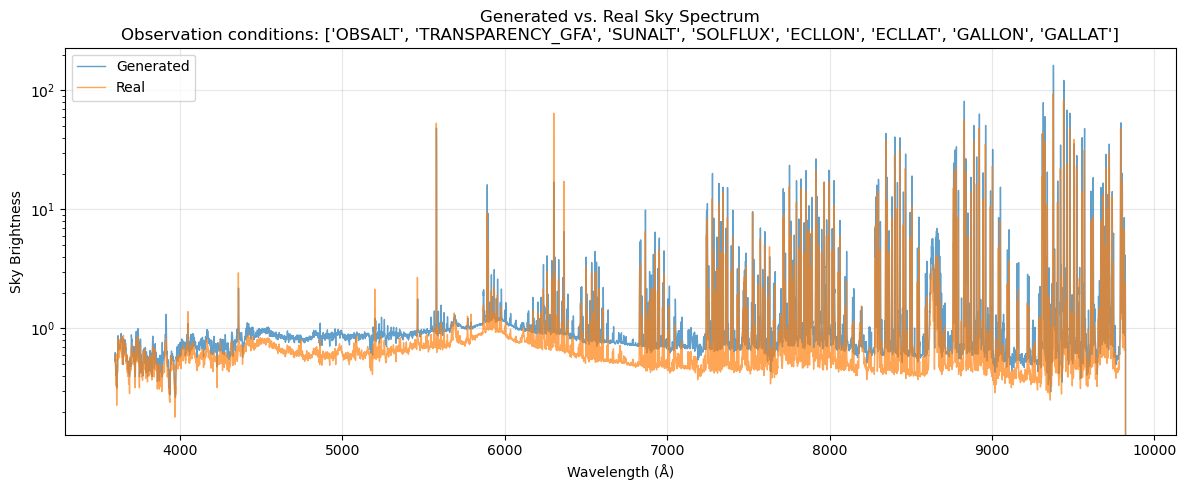


Conditioning values:
  OBSALT              : 57.36
  TRANSPARENCY_GFA    : 0.92
  SUNALT              : -20.94
  SOLFLUX             : 71.20
  ECLLON              : 151.31
  ECLLAT              : -9.32
  GALLON              : 236.67
  GALLAT              : 42.10


In [13]:
# Generate a spectrum matching a real observation
test_idx = 1
test_cond = conditioning[test_idx]

sampler = LatentDiffusionSampler(
    ldm_model=ldm,
    vae_model=vae,
    sigma_data=ldm_meta["training"]["sigma_data"],
    conditioning_scaler=ldm_meta["training"]["conditioning_scaler"],
    num_steps=250,
    latent_channels=1,
    latent_dim=8
)

spec = sampler.sample(
    key=jr.PRNGKey(0),
    conditioning=test_cond,
    guidance_scale=1.0
)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(wavelength, spec.squeeze(), alpha=0.7, label='Generated', linewidth=1)
plt.plot(wavelength, flux[test_idx], alpha=0.7, label='Real', linewidth=1)
plt.legend()
plt.xlabel('Wavelength (Å)')
plt.ylabel('Sky Brightness')
plt.yscale('log')
plt.title(f'Generated vs. Real Sky Spectrum\nObservation conditions: {CONDITIONING_COLS}')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print conditioning values
print("\nConditioning values:")
for col, val in zip(CONDITIONING_COLS, test_cond):
    print(f"  {col:20s}: {val:.2f}")

## Moon-Contaminated Sky Model

The LDM moon model is trained on moon-contaminated observations with different conditioning variables. Let's demonstrate how to use it.

### Load Moon-Contaminated Data

The moon-contaminated subset filters for:
- Sun altitude < -20° (nighttime)
- Moon altitude > 5° (Moon above horizon)
- Moon fraction > 0.5 (Moon more than half illuminated)
- Moon separation ≤ 90° (Moon within 90 degrees of observation)
- Valid transparency measurements

In [14]:
# Load moon-contaminated subset
wavelength_moon, flux_moon, metadata_moon = vac.load_moon_contaminated(enrich=True)

print(f"Moon-contaminated subset: {len(metadata_moon)} exposures")
print(f"Flux shape: {flux_moon.shape}")
print(f"\nMoon-related metadata columns:")
for col in ["MOONALT", "MOONFRAC", "MOONSEP"]:
    print(f"  {col}: min={metadata_moon[col].min():.2f}, max={metadata_moon[col].max():.2f}")

Moon-contaminated subset: 1931 exposures
Flux shape: (1931, 7781)

Moon-related metadata columns:
  MOONALT: min=5.14, max=84.10
  MOONFRAC: min=0.50, max=1.00
  MOONSEP: min=31.51, max=89.97


### Define Moon Model Conditioning

The moon model uses different conditioning variables optimized for moon-contaminated observations:

In [15]:
# Moon model conditioning: OBSALT, TRANSPARENCY_GFA, SUNALT, MOONALT, MOONSEP, MOONFRAC
MOON_CONDITIONING_COLS = [
    "OBSALT", "TRANSPARENCY_GFA", "SUNALT", "MOONALT", "MOONSEP", "MOONFRAC"
]

moon_conditioning = metadata_moon[MOON_CONDITIONING_COLS].to_numpy(dtype=np.float32)
print(f"Moon conditioning shape: {moon_conditioning.shape}")
print(f"\nConditioning columns: {MOON_CONDITIONING_COLS}")

Moon conditioning shape: (1931, 6)

Conditioning columns: ['OBSALT', 'TRANSPARENCY_GFA', 'SUNALT', 'MOONALT', 'MOONSEP', 'MOONFRAC']


### Load Moon LDM Model

The moon model has `meta_dim=6` (vs dark model's `meta_dim=8`) to match the different conditioning variables.

In [16]:
# Load the moon LDM model
ldm_moon, ldm_moon_meta = load_builtin("ldm_moon")

print("Moon LDM Architecture:")
print(f"  Model architecture: {ldm_moon_meta['arch']}")
print(f"  Meta_dim: {ldm_moon_meta['arch']['meta_dim']}")
print(f"  Model schema version: {ldm_moon_meta['schema']}")

# Note: The VAE is the same for both dark and moon models (same spectral space)

Moon LDM Architecture:
  Model architecture: {'in_ch': 1, 'out_ch': 1, 'meta_dim': 6, 'hidden': 32, 'levels': 2, 'emb_dim': 32}
  Meta_dim: 6
  Model schema version: 1


### Filter Moon Data to Validation-Only Samples

In [17]:
# Filter moon data to validation-only samples
val_mask_moon = get_validation_mask(metadata_moon, ldm_moon_meta)
flux_moon = flux_moon[val_mask_moon]
metadata_moon = metadata_moon[val_mask_moon].reset_index(drop=True)
moon_conditioning = moon_conditioning[val_mask_moon]

print(f"Validation-only moon subset: {len(metadata_moon)} exposures")
print(f"Flux shape: {flux_moon.shape}")
print(f"Conditioning shape: {moon_conditioning.shape}")

Found 377 of 1089 validation EXPIDs in metadata.
Validation-only moon subset: 377 exposures
Flux shape: (377, 7781)
Conditioning shape: (377, 6)


### Generate Moon-Contaminated Spectra

In [18]:
# Create moon model sampler
moon_sampler = LatentDiffusionSampler(
    ldm_model=ldm_moon,
    vae_model=vae,  # Same VAE for all models
    sigma_data=ldm_moon_meta["training"]["sigma_data"],
    conditioning_scaler=ldm_moon_meta["training"]["conditioning_scaler"],
    num_steps=250,
    latent_channels=1,
    latent_dim=8
)

print(moon_sampler)

# Generate samples using real moon-contaminated conditions
test_moon_idx = 0
test_moon_cond = moon_conditioning[test_moon_idx:test_moon_idx+1]

moon_spec = moon_sampler.sample(
    key=jr.PRNGKey(42),
    conditioning=test_moon_cond,
    guidance_scale=1.0
)

print(f"\nGenerated moon-contaminated spectrum shape: {moon_spec.shape}")

LatentDiffusionSampler(
  num_steps=250,
  sigma_data=6.798424243927002,
  sigma_range=[0.002, 80.0],
  rho=7.0,
  latent_shape=(1, 8),
  auto_normalize=True
)

Generated moon-contaminated spectrum shape: (1, 7781)


### Visualize Moon vs Dark Spectra

Moon-contaminated observation conditions:
  OBSALT              : 70.08
  TRANSPARENCY_GFA    : 1.05
  SUNALT              : -46.39
  MOONALT             : 16.89
  MOONSEP             : 71.27
  MOONFRAC            : 0.50


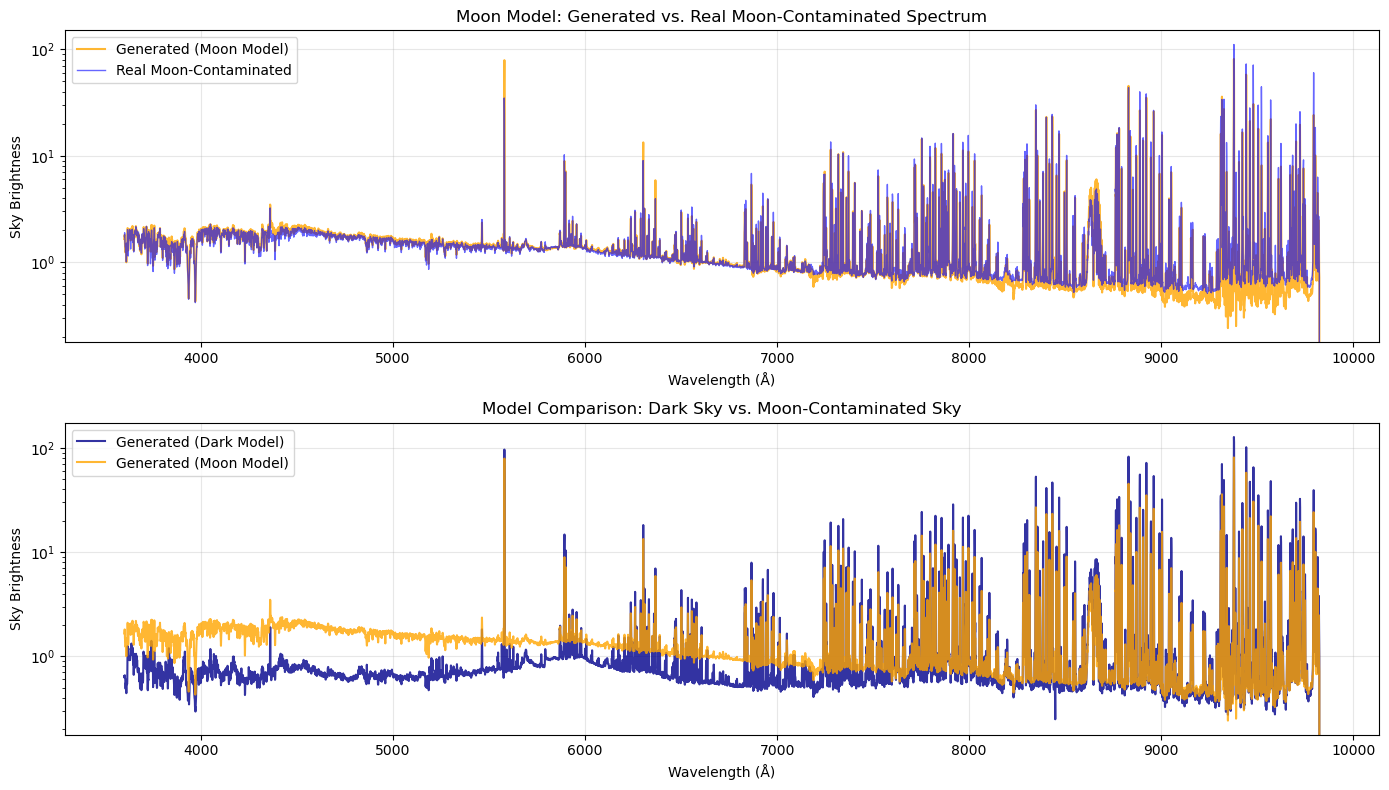


Dark model conditioning (8 features): ['OBSALT', 'TRANSPARENCY_GFA', 'SUNALT', 'SOLFLUX', 'ECLLON', 'ECLLAT', 'GALLON', 'GALLAT']
Moon model conditioning (6 features): ['OBSALT', 'TRANSPARENCY_GFA', 'SUNALT', 'MOONALT', 'MOONSEP', 'MOONFRAC']


In [19]:
# Compare generated moon spectrum with real moon-contaminated observation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Generated vs Real Moon Spectrum
ax1.plot(wavelength_moon, moon_spec.squeeze(), alpha=0.8, label='Generated (Moon Model)', linewidth=1.5, color='orange')
ax1.plot(wavelength_moon, flux_moon[test_moon_idx], alpha=0.6, label='Real Moon-Contaminated', linewidth=1, color='blue')
ax1.set_xlabel('Wavelength (Å)')
ax1.set_ylabel('Sky Brightness')
ax1.set_yscale('log')
ax1.set_title('Moon Model: Generated vs. Real Moon-Contaminated Spectrum')
ax1.legend()
ax1.grid(alpha=0.3)

# Print moon conditions
print("Moon-contaminated observation conditions:")
for col, val in zip(MOON_CONDITIONING_COLS, test_moon_cond.squeeze()):
    print(f"  {col:20s}: {val:.2f}")

# Plot 2: Compare Dark vs Moon Spectra (both generated)
# Generate a dark spectrum for comparison
dark_spec_comparison = sampler.sample(
    key=jr.PRNGKey(42),
    conditioning=conditioning[0:1],
    guidance_scale=1.0
)

ax2.plot(wavelength, dark_spec_comparison.squeeze(), alpha=0.8, label='Generated (Dark Model)', linewidth=1.5, color='darkblue')
ax2.plot(wavelength_moon, moon_spec.squeeze(), alpha=0.8, label='Generated (Moon Model)', linewidth=1.5, color='orange')
ax2.set_xlabel('Wavelength (Å)')
ax2.set_ylabel('Sky Brightness')
ax2.set_yscale('log')
ax2.set_title('Model Comparison: Dark Sky vs. Moon-Contaminated Sky')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Dark model conditioning (8 features):", CONDITIONING_COLS)
print("Moon model conditioning (6 features):", MOON_CONDITIONING_COLS)
print("="*60)

## Twilight Sky Model

The LDM twilight model is trained on sun-contaminated (twilight) observations with different conditioning variables. Let's demonstrate how to use it.

### Load Twilight-Contaminated Data

The twilight subset filters for:
- Sun altitude > -20° (Sun near or above horizon - twilight)
- Moon altitude ≤ -5° (Moon below horizon to exclude moon contamination)
- Sun separation ≤ 110° (Sun-pointing angular separation constraint)
- Valid transparency measurements

In [20]:
# Load twilight subset
wavelength_twilight, flux_twilight, metadata_twilight = vac.load_sun_contaminated(enrich=True)

print(f"Twilight subset: {len(metadata_twilight)} exposures")
print(f"Flux shape: {flux_twilight.shape}")
print(f"\nSun-related metadata columns:")
for col in ["SUNALT", "SUNSEP"]:
    print(f"  {col}: min={metadata_twilight[col].min():.2f}, max={metadata_twilight[col].max():.2f}")

Twilight subset: 298 exposures
Flux shape: (298, 7781)

Sun-related metadata columns:
  SUNALT: min=-19.97, max=-10.14
  SUNSEP: min=70.84, max=109.53


### Define Twilight Model Conditioning

The twilight model uses 4 conditioning variables optimized for twilight observations:

In [21]:
# Twilight model conditioning: OBSALT, TRANSPARENCY_GFA, SUNALT, SUNSEP
TWILIGHT_CONDITIONING_COLS = [
    "OBSALT", "TRANSPARENCY_GFA", "SUNALT", "SUNSEP"
]

twilight_conditioning = metadata_twilight[TWILIGHT_CONDITIONING_COLS].to_numpy(dtype=np.float32)
print(f"Twilight conditioning shape: {twilight_conditioning.shape}")
print(f"\nConditioning columns: {TWILIGHT_CONDITIONING_COLS}")

Twilight conditioning shape: (298, 4)

Conditioning columns: ['OBSALT', 'TRANSPARENCY_GFA', 'SUNALT', 'SUNSEP']


### Load Twilight LDM Model

The twilight model has `meta_dim=4` (vs dark model's `meta_dim=8` and moon model's `meta_dim=6`) to match the different conditioning variables.

In [22]:
# Load the twilight LDM model
ldm_twilight, ldm_twilight_meta = load_builtin("ldm_twilight")

print("Twilight LDM Architecture:")
print(f"  Model architecture: {ldm_twilight_meta['arch']}")
print(f"  Meta_dim: {ldm_twilight_meta['arch']['meta_dim']}")
print(f"  Model schema version: {ldm_twilight_meta['schema']}")

# Note: The VAE is the same for all models (same spectral space)

Twilight LDM Architecture:
  Model architecture: {'in_ch': 1, 'out_ch': 1, 'meta_dim': 4, 'hidden': 32, 'levels': 2, 'emb_dim': 32}
  Meta_dim: 4
  Model schema version: 1


### Filter Twilight Data to Validation-Only Samples

In [23]:
# Filter twilight data to validation-only samples
val_mask_twilight = get_validation_mask(metadata_twilight, ldm_twilight_meta)
flux_twilight = flux_twilight[val_mask_twilight]
metadata_twilight = metadata_twilight[val_mask_twilight].reset_index(drop=True)
twilight_conditioning = twilight_conditioning[val_mask_twilight]

print(f"Validation-only twilight subset: {len(metadata_twilight)} exposures")
print(f"Flux shape: {flux_twilight.shape}")
print(f"Conditioning shape: {twilight_conditioning.shape}")

Found 54 of 188 validation EXPIDs in metadata.
Validation-only twilight subset: 54 exposures
Flux shape: (54, 7781)
Conditioning shape: (54, 4)


### Generate Twilight Spectra

In [24]:
# Create twilight model sampler
twilight_sampler = LatentDiffusionSampler(
    ldm_model=ldm_twilight,
    vae_model=vae,  # Same VAE for all models
    sigma_data=ldm_twilight_meta["training"]["sigma_data"],
    conditioning_scaler=ldm_twilight_meta["training"]["conditioning_scaler"],
    num_steps=250,
    latent_channels=1,
    latent_dim=8
)

print(twilight_sampler)

# Generate samples using real twilight conditions
test_twilight_idx = 0
test_twilight_cond = twilight_conditioning[test_twilight_idx:test_twilight_idx+1]

twilight_spec = twilight_sampler.sample(
    key=jr.PRNGKey(42),
    conditioning=test_twilight_cond,
    guidance_scale=1.0
)

print(f"\nGenerated twilight spectrum shape: {twilight_spec.shape}")

LatentDiffusionSampler(
  num_steps=250,
  sigma_data=6.967531204223633,
  sigma_range=[0.002, 80.0],
  rho=7.0,
  latent_shape=(1, 8),
  auto_normalize=True
)

Generated twilight spectrum shape: (1, 7781)


### Visualize Twilight vs Dark vs Moon Spectra

Twilight observation conditions:
  OBSALT              : 55.60
  TRANSPARENCY_GFA    : 1.03
  SUNALT              : -18.97
  SUNSEP              : 90.20


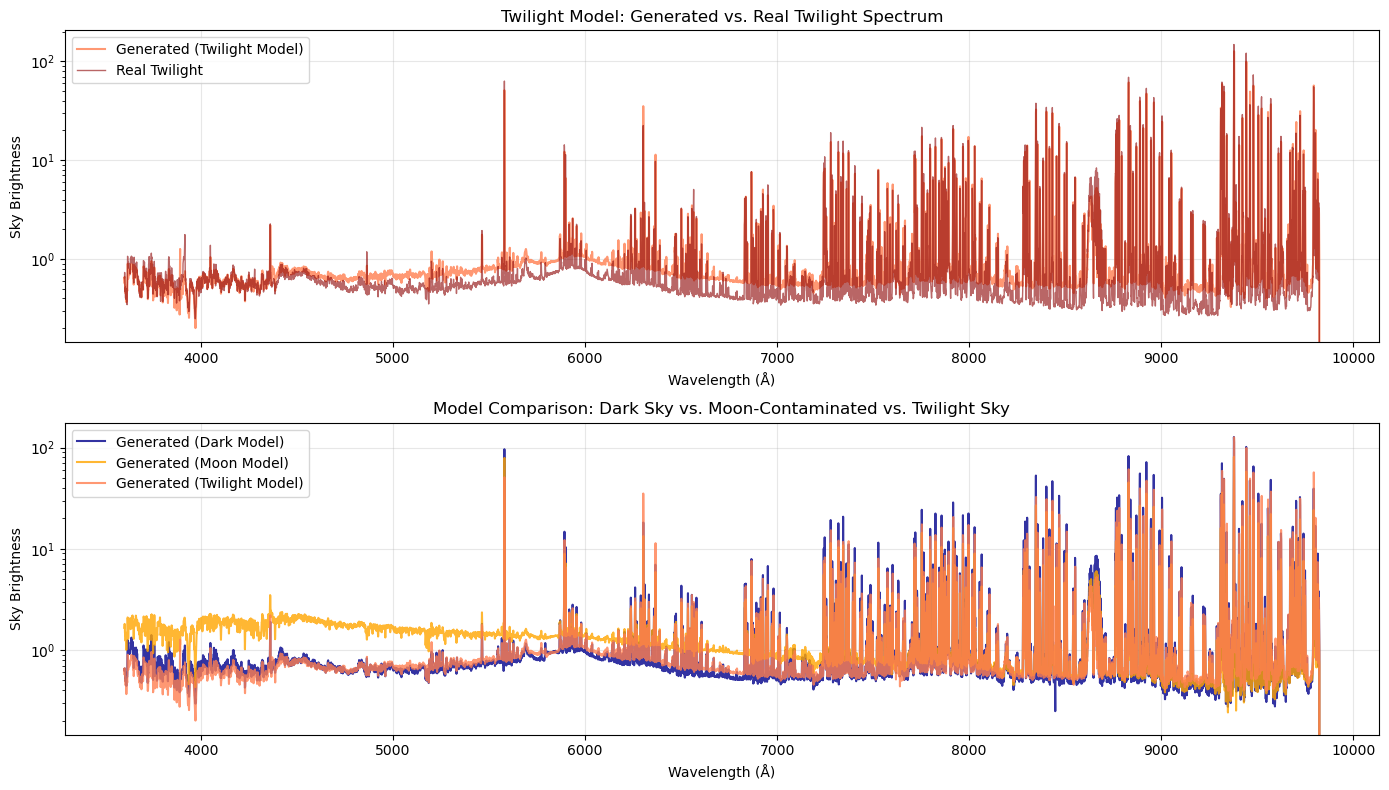


Dark model conditioning (8 features): ['OBSALT', 'TRANSPARENCY_GFA', 'SUNALT', 'SOLFLUX', 'ECLLON', 'ECLLAT', 'GALLON', 'GALLAT']
Moon model conditioning (6 features): ['OBSALT', 'TRANSPARENCY_GFA', 'SUNALT', 'MOONALT', 'MOONSEP', 'MOONFRAC']
Twilight model conditioning (4 features): ['OBSALT', 'TRANSPARENCY_GFA', 'SUNALT', 'SUNSEP']


In [25]:
# Compare generated twilight spectrum with real twilight observation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Generated vs Real Twilight Spectrum
ax1.plot(wavelength_twilight, twilight_spec.squeeze(), alpha=0.8, label='Generated (Twilight Model)', linewidth=1.5, color='coral')
ax1.plot(wavelength_twilight, flux_twilight[test_twilight_idx], alpha=0.6, label='Real Twilight', linewidth=1, color='darkred')
ax1.set_xlabel('Wavelength (Å)')
ax1.set_ylabel('Sky Brightness')
ax1.set_yscale('log')
ax1.set_title('Twilight Model: Generated vs. Real Twilight Spectrum')
ax1.legend()
ax1.grid(alpha=0.3)

# Print twilight conditions
print("Twilight observation conditions:")
for col, val in zip(TWILIGHT_CONDITIONING_COLS, test_twilight_cond.squeeze()):
    print(f"  {col:20s}: {val:.2f}")

# Plot 2: Compare Dark vs Moon vs Twilight Spectra (all generated)
ax2.plot(wavelength, dark_spec_comparison.squeeze(), alpha=0.8, label='Generated (Dark Model)', linewidth=1.5, color='darkblue')
ax2.plot(wavelength_moon, moon_spec.squeeze(), alpha=0.8, label='Generated (Moon Model)', linewidth=1.5, color='orange')
ax2.plot(wavelength_twilight, twilight_spec.squeeze(), alpha=0.8, label='Generated (Twilight Model)', linewidth=1.5, color='coral')
ax2.set_xlabel('Wavelength (Å)')
ax2.set_ylabel('Sky Brightness')
ax2.set_yscale('log')
ax2.set_title('Model Comparison: Dark Sky vs. Moon-Contaminated vs. Twilight Sky')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Dark model conditioning (8 features):", CONDITIONING_COLS)
print("Moon model conditioning (6 features):", MOON_CONDITIONING_COLS)
print("Twilight model conditioning (4 features):", TWILIGHT_CONDITIONING_COLS)
print("="*80)

## Summary

This notebook demonstrated:

1. **Data Enrichment**: Using `desisky.data` functions to add solar flux and coordinate transformations
2. **Model Loading**: Loading pre-trained VAE and LDM models with `desisky.io.load_builtin()`
3. **Dark Sky Sampling**: Using `LatentDiffusionSampler` with the `ldm_dark` model (8 conditioning features)
4. **Moon-Contaminated Sky Sampling**: Using `LatentDiffusionSampler` with the `ldm_moon` model (6 conditioning features)
5. **Twilight Sky Sampling**: Using `LatentDiffusionSampler` with the `ldm_twilight` model (4 conditioning features)
6. **Model Comparison**: Visualizing differences between dark, moon-contaminated, and twilight sky spectra

### Available Models

- **`ldm_dark`**: Trained on dark-time observations (SUNALT < -20°, MOONALT < -5°)
  - Conditioning: `[OBSALT, TRANSPARENCY_GFA, SUNALT, SOLFLUX, ECLLON, ECLLAT, GALLON, GALLAT]`
  - Use case: Dark sky observations, zodiacal light, integrated starlight
  
- **`ldm_moon`**: Trained on moon-contaminated observations (MOONALT > 5°, MOONFRAC > 0.5, MOONSEP ≤ 90°)
  - Conditioning: `[OBSALT, TRANSPARENCY_GFA, SUNALT, MOONALT, MOONSEP, MOONFRAC]`
  - Use case: Moon-contaminated sky, moonlight modeling
  
- **`ldm_twilight`**: Trained on twilight observations (SUNALT > -20°, MOONALT ≤ -5°)
  - Conditioning: `[OBSALT, TRANSPARENCY_GFA, SUNALT, SUNSEP]`
  - Use case: Twilight sky, solar contamination modeling